In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import pandas as pd

In [2]:
'''Micol'''
path_raw = '/Users/micol/Documents/Imperial/Year4/Master_Project/raw_spectra' #path with raw spectra files
path_logs = '/Users/micol/Documents/Imperial/Year4/Master_Project/bruker_logs' #path with eventlog and temperatures

'''Rachel'''
#path_raw = '//icnas4.cc.ic.ac.uk/rs5115/MSci Project/raw_spectra'
#path_logs = '//icnas4.cc.ic.ac.uk/rs5115/MSci Project/bruker_logs'

temperature_log = 'thursday2-20180927113645.log' #log of temperatures
event_log = 'EventLog_20180927112225.log' #event log

In [3]:
all_the_files = np.array([i for i in os.listdir(path_raw) if os.path.isfile(os.path.join(path_raw,i)) and i.startswith('IC_raw_spectra_')]) #all files in directory starting with 'IC_raw_spectra'
file_array = [f.strip('IC_raw_spectra.tx') for f in all_the_files] #list of filenames in original (wrong) order

file_integers = sorted([int(i) for i in file_array]) #number converted to sorted integers (not naturally done)
all_files_list = ['IC_raw_spectra_'+str(num)+'.txt' for num in file_integers] #file list, in order

In [4]:
"""removing files without associated temperature measurement"""

def read_temperatures_check(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list
    temp1 = [float(b) for b in (lines[1].split())[6:]]
    tempHBB1 = temp1[0]

    return tempHBB1

In [5]:
delete_files = [] #files where there is no temperature measurement

for f in all_files_list:
    if read_temperatures_check(path_raw, f) == 0.0:
        delete_files.append(f)

files_list = [x for x in all_files_list if x not in delete_files]

In [6]:
"""retrieving times from files"""

def read_times(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list
    times = lines[0].split() #retrieve times of beginning of all spectra in a file
    return times

In [7]:
all_times_list = [] #final time list [374x4] (in HH:MM:SS.microsec format)

for f in range(len(files_list)): #go through files_list and extract times
    all_times_list.append(read_times(path_raw, files_list[f]))

flat_list = [item for sublist in all_times_list for item in sublist] #1D list of all times (in HH:MM:SS.microsec format)

spectrum_times = [] #final time list [(374*4)x1] in seconds from midnight format

for i in flat_list: #convert times to seconds format
    time = datetime.datetime.strptime(i, '%H:%M:%S.%f')
    spectrum_times.append((time.microsecond)/1000000 +time.second+time.minute*60+time.hour*3600)

Code up to this point returns:

$\textbf{spectrum_times}$: a list of times of all spectra for which the temperature is not zero

$\textbf{files_list}$: a list of all raw files for which temperature is not zero

In [8]:
time_col_name = 'Time' # name the time column in all subsequent dataframes

In [9]:
# Read the log file - extract log_times and log_h_or_c
log_file = open(os.path.join(path_logs, event_log)).readlines()

log_file_list = []
for i in log_file[9:-3]: # leave out 'title' and 'footnotes' of the log file
    log_file_list.append(i.split(' '))
for i in log_file_list:
    i.pop(5)
    i.pop(4)
    i.pop(3)
    i.pop(0)
# each item has length either 3 or 4. Length 4 is at start of h/c BB measurement

In [10]:
'''create log_h_c which identifies whether spectrometer is looking at hot or cold blackbody for each associated log_times entry from the EventLog (50 hot and 50 cold)'''

log_times = [] # all times in seconds since midnight
log_times_real = []
log_h_c = []

for i in log_file_list:
    log_times_real.append(i[0])
    time = datetime.datetime.strptime(i[0]+i[1], '%I:%M:%S%p')
    log_times.append(time.second+time.minute*60+time.hour*3600)
    if len(i) == 4:
        log_h_c.append(i[-1][0])
    elif len(i) == 3:
        log_h_c.append(log_h_c[-1])
    else:
        raise Exception('Error')

In [11]:
hc_log = pd.DataFrame(
    {'Real Time': log_times_real,
    time_col_name: log_times,
     'h/c': log_h_c,
    })
hc_log.head()

,Real Time,Time,h/c
0,12:23:01,44581,h
1,12:23:03,44583,h
2,12:23:05,44585,h
3,12:23:08,44588,h
4,12:23:10,44590,h


In [12]:
'''insert_row inserts a row into a dataframe after a given index and then reindex all rows in ascending order'''

def insert_row(i, df, line):
    dfA = df.iloc[:i, ]
    dfB = df.iloc[i:, ]
    df = dfA.append(line).append(dfB).reset_index(drop = True) # Our code differs here
    return df

In [13]:
times = spectrum_times
times.sort(reverse = True) #need to insert rows into dataframe in reverse order in order not to get messed up with indices

#scan log_times, and insert spectra at corresponding times, with 'Nan' in the h_c column (by default)
for t in times:
    i=0
    if t > log_times[0]:
        while hc_log.at[i, time_col_name] <= t:
            i += 1   
        line = pd.DataFrame([t], columns = [time_col_name])
        hc_log = insert_row(i, hc_log, line)
    else:
        line = pd.DataFrame([t], columns = [time_col_name])
        hc_log = insert_row(i, hc_log, line)

In [14]:
hc_list = []

for i in range(hc_log.shape[0]-1):
    value = hc_log.at[i, 'h/c']
    if value != 'c' and value != 'h':
        hc_list.append(hc_log.iloc[i+1]['h/c']) # the spectra are assigned the h_c value of the following time

In [15]:
times.sort() # now they are back in ascending order

hc_and_times = pd.DataFrame(
    {'Real Time': flat_list,
    'Spectrum': times,
     'hc': hc_list
    })

hc_and_times[:10]

,Real Time,Spectrum,hc
0,12:36:59.910,45419.910,c
1,12:37:13.383,45433.383,c
2,12:37:26.855,45446.855,c
3,12:37:40.268,45460.268,c
4,12:37:58.496,45478.496,c
5,12:38:11.910,45491.910,c
6,12:38:25.383,45505.383,c
7,12:38:38.795,45518.795,c
8,12:38:58.796,45538.796,h
9,12:39:12.269,45552.269,h


the Nans at the end are because the EventLog is no longer logging h or c while spectra are still being taken

In [16]:
# Read log temperature file
def read_log_file_temperature(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines()
    hour_times = []
    for line in lines:
        hour_times.append(line[9:17])
    time = [(datetime.datetime.strptime(i[0:17], '%Y%m%d,%H:%M:%S')) for i in lines]
    time_sec = [time[i].second+time[i].minute*60+time[i].hour*3600 for i in range(len(time))]    
    temp_cold = [float((i[-6:-1])) for i in lines] # temperature of external black body
    temp_hot = [float((i[-12:-7])) for i in lines] # temperature of external black body
    return temp_hot, temp_cold, time, time_sec, hour_times

In [17]:
temp_hot, temp_cold, time, temp_time, hour_times = read_log_file_temperature(path_logs, temperature_log)

In [18]:
temp_log = pd.DataFrame(
    {'Real_Time': hour_times,
    time_col_name: temp_time,
     'hot': temp_hot,
     'cold': temp_cold
    })
temp_log[-5:]

,Real_Time,Time,cold,hot
10133,18:32:05,66725,29.23,69.88
10134,18:32:07,66727,29.22,69.88
10135,18:32:09,66729,29.23,69.88
10136,18:32:11,66731,29.23,69.88
10137,18:32:13,66733,29.23,69.88


In [19]:
temps_avg = []
temps_std = []

i=0
for spectrum in times[:-1]:
    times_list = list(filter(lambda t: (t>spectrum and t<times[i+1]) , temp_time))
    index_list = [temp_time.index(item) for item in times_list]
    if hc_list[i] == 'h':
        temps_list = [temp_hot[a] for a in index_list]
    elif hc_list[i] == 'c':
        temps_list = [temp_cold[a] for a in index_list]
    temps_avg.append(np.average(temps_list))
    temps_std.append(np.std(temps_list))
    i+=1

In [20]:
final_frame = pd.DataFrame(
    {'Real Time': flat_list[:-1], #get rid of last value because the hc_log loops around and puts a fake 'c' value for last row
    time_col_name: times[:-1],
     'h_or_c': hc_list[:-1],
     'temp_avg': temps_avg,
     'temp_std': temps_std,
    })
final_frame[-16:] #still includes Nan values at the end

,Real Time,Time,h_or_c,temp_avg,temp_std
1399,18:23:39.776,66219.776,c,29.222500,4.330127e-03
1400,18:23:58.415,66238.415,h,69.923333,4.714045e-03
1401,18:24:11.858,66251.858,h,69.916667,4.714045e-03
1402,18:24:25.353,66265.353,h,69.910000,1.421085e-14
1403,18:24:38.794,66278.794,h,69.913000,4.582576e-03
1404,18:24:57.846,66297.846,h,69.910000,1.421085e-14
1405,18:25:11.341,66311.341,h,69.908000,4.000000e-03
1406,18:25:24.836,66324.836,h,69.910000,1.421085e-14
1407,18:25:38.281,66338.281,h,69.901984,1.000157e-02
1408,18:29:53.151,66593.151,NaN,69.901984,1.000157e-02


In [21]:
temps_avg_4 = []
temps_std_4 = []

while len(times)%4 != 0: #because we want to group them into groups of 4 spectra
    del times[-1]

times_4 = np.reshape(np.array(times), (int(np.floor(len(times)/4)),4)) #354x4 array of all times, grouped into arrays of length 4

i=0
for spectra in times_4[:-1]: #get rid of remaining Nans at the bottom
    times_list = list(filter(lambda t: (t>spectra[0] and t<times_4[i+1][0]) , temp_time)) # only keep the temps between the beginning of the spectrum and the beginning of the next one  
    #times_list are all times in the temperature log associated with a value in times_4
    index_list = [temp_time.index(item) for item in times_list] # indices associated to the above times   
    if hc_list[i*4] == 'h' and i != 0:
        temps_list = [temp_hot[a] for a in index_list]
    elif hc_list[i*4] == 'c' and i != 0:
        temps_list = [temp_cold[a] for a in index_list]
    elif i == 0:
        if hc_list[i] == 'h':
            temps_list = [temp_hot[a] for a in index_list]
        elif hc_list[i] == 'c':
            temps_list = [temp_cold[a] for a in index_list]
            
    temps_avg_4.append(np.average(temps_list))
    temps_std_4.append(np.std(temps_list)) 
    i+=1

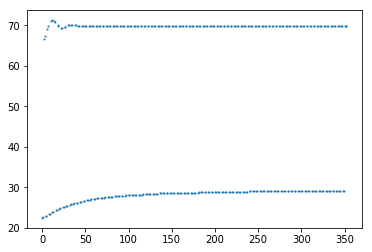

In [22]:
# check that there are no outliers, ie that we averaged correctly
plt.scatter(np.arange(len(temps_avg_4)), temps_avg_4, s=1)
plt.show()

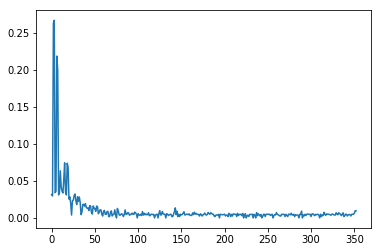

In [23]:
#plot stds - NB this includes stds for hot and cold BBs
plt.plot(np.arange(len(temps_std_4)), temps_std_4)
plt.show()

In [24]:
hc_list_4 = hc_list[0::4]
spectra_times_4 = [time[0] for time in times_4][:-1] #list of times of first spectra in array of 4 spectra

for a in hc_list_4[:-1]:
    if a != 'h' and a != 'c':
        b = hc_list_4[:-1].index(a)

final_frame_4 = pd.DataFrame(
    {'Real Time': flat_list[0:-4:4],
     time_col_name: spectra_times_4,
     'temp_std': temps_std_4,
     'h_or_c': hc_list_4[:-1],
     'temp_avg': temps_avg_4
    })

final_frame_4 = final_frame_4.iloc[:b] #delete row with NaN in it - this assumes only one row needs to be deleted: find a way to delete all rows with Nan in it

final_frame_4

,Real Time,Time,h_or_c,temp_avg,temp_std
0,12:36:59.910,45419.910,c,22.467143,0.031493
1,12:37:58.496,45478.496,c,22.579643,0.029699
2,12:38:58.796,45538.796,h,66.579643,0.262712
3,12:39:57.323,45597.323,h,67.300000,0.266833
4,12:40:56.645,45656.645,c,22.918519,0.034070
5,12:41:55.991,45715.991,c,23.041071,0.035990
6,12:42:54.887,45774.887,h,69.211071,0.218523
7,12:43:54.205,45834.205,h,69.823929,0.199075
8,12:44:54.485,45894.485,c,23.394074,0.031063
9,12:45:53.806,45953.806,c,23.501000,0.033995


In [25]:
h = 6.626e-34
c = 3.0e+8
k = 1.381e-23

planck_a = 2*h*(c**2)
planck_e = h*c/k

def planck(wavenumber, T): # T in Kelvin, wavenumber in cm^-1
    radiance = 100*planck_a*((wavenumber*100)**3)/(np.exp(planck_e*(wavenumber*100)/T)-1)
    return radiance #returns radiance in $W m^{-2} sr^{-1} (cm^{-1})^{-1}$

In [26]:
def read_wavenumbers(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list
    wns = []
    for i in lines[5:]:
        line = i.split()
        split_lines = [float(a) for a in line]
        wns.append(split_lines[0])
    return wns

raw_wavenumbers = read_wavenumbers(path_raw, files_list[0]) #all wavenumbers are the same in all files so just need to read from the first file
wavenums = raw_wavenumbers

Time 12:37:58.496
Average temp 22.579642857142858
Temperature Std 0.02969874250069263


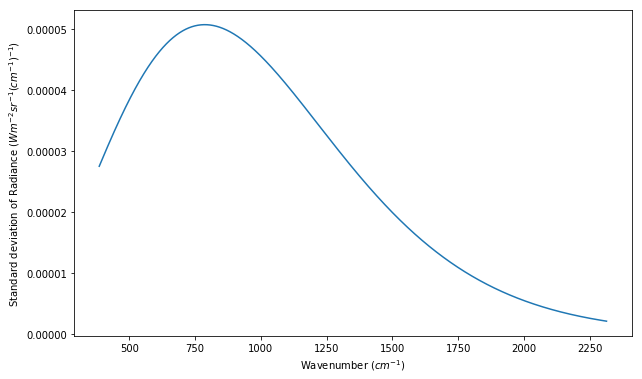

In [27]:
#Plot standard deviation (large radiance - average) of radiance from data of standard deviation of temperature

def plot_rad_std_dev(spectrum):
    temp_avg = final_frame_4.at[spectrum,'temp_avg'] #get it from the dataframe
    std = final_frame_4.at[spectrum,'temp_std']
    print('Time {}'.format(final_frame_4.at[spectrum, 'Real Time']))
    print('Average temp {}'.format(temp_avg))
    print('Temperature Std {}'.format(std))

    rad_avg = [planck(wn, temp_avg+273.15) for wn in wavenums]
    rad_minus = [planck(wn, temp_avg+273.15-std) for wn in wavenums]
    rad_plus = [planck(wn, temp_avg+273.15+std) for wn in wavenums]
    
    fig = plt.figure(figsize=(10,6)) 
    y = (np.array(rad_plus)-np.array(rad_avg))
    plt.plot(wavenums, y)
    plt.ylabel('Standard deviation of Radiance ($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
    plt.xlabel('Wavenumber ($cm^{-1}$)')
    plt.show()

spectra_indices = [1,2,141,142,347,348] #random sets of hot and cold spectra
plot_rad_std_dev(1)

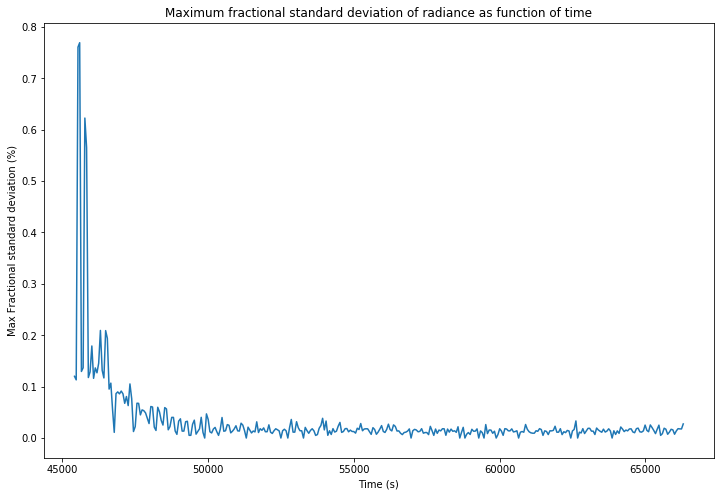

In [28]:
# Plot max fractional standard deviation of radiance as function of time
max_fractional_std = []
temp_spectral_std_dev = []
time = []

for spectrum in np.arange(len(spectra_times_4)-1):
    time.append(final_frame_4.at[spectrum,'Time']) #get times, temperatures, and temperature std dev from the dataframe
    temp_avg = final_frame_4.at[spectrum,'temp_avg']
    std = final_frame_4.at[spectrum,'temp_std']
    
    rad_avg = [planck(wn, temp_avg+273.15) for wn in wavenums]
    rad_plus = [planck(wn, temp_avg+273.15+std) for wn in wavenums]
    spec_std = np.array(rad_plus) - np.array(rad_avg)
    temp_spectral_std_dev.append(spec_std)

    spec_fractional_std = [i/j for (i,j) in zip(spec_std, rad_avg)]
    max_fractional_std.append(np.max(spec_fractional_std)*100)

fig = plt.figure(figsize=(12,8))
plt.plot(time, max_fractional_std)
plt.ylabel('Max Fractional standard deviation (%)')
plt.xlabel('Time (s)')
plt.title('Maximum fractional standard deviation of radiance as function of time')
plt.show()

In [29]:
def read_all_raw_spectra(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines() #finds all lines in file as string elements in "lines" list

    sp1 = []
    sp2 = []
    sp3 = []
    sp4 = []
    
    for i in lines[5:]:
        line = i.split()
        split_lines = [float(a) for a in line]
        sp1.append(split_lines[1])
        sp2.append(split_lines[2])
        sp3.append(split_lines[3])
        sp4.append(split_lines[4])
    avg_4_spec = 0.25*(np.array(sp1) + np.array(sp2) + np.array(sp3) + np.array(sp4))
    
    return avg_4_spec #list of raw value as function of wavenumber averaged over the 4 spectra

average_4_spectra = [read_all_raw_spectra(path_raw, files_list[f]) for f in range(len(files_list)-1)] #list of 352 elements, which is a list of 8000 points averaged over the 4 spectra

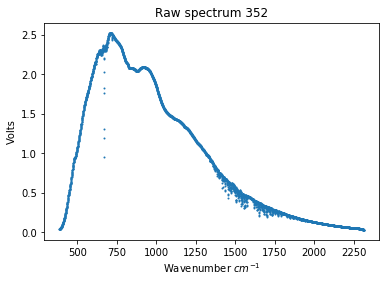

In [30]:
# Plot a raw spectrum
def raw_spectrum_plot(num): #num = the spectrum you want to plot (0 to 352)
    plt.scatter(wavenums, average_4_spectra[num], s=1)
    plt.title('Raw spectrum ' + str(num))
    plt.xlabel('Wavenumber $cm^{-1}$')
    plt.ylabel('Volts')
    plt.show()

raw_spectrum_plot(352)

In [31]:
def response_fn(spectrum_number): #returns the response function at some time and wavenumber
    
    (a,b) = (average_4_spectra[spectrum_number], average_4_spectra[spectrum_number + 1])
    if a[1000] < b[1000]:
        V_c = a
        V_h = b
    else:
        V_c = b
        V_h = a

    V_diff = np.array(V_h)-np.array(V_c)
    
    (e,f) = (final_frame_4.at[spectrum_number,'temp_avg'], final_frame_4.at[spectrum_number+1,'temp_avg'])
    if e<f:
        temp_average_c = e
        temp_average_h = f
    else:
        temp_average_c = f
        temp_average_h = e
    
    radiances_avg_h = [planck(wn, temp_average_h+273.15) for wn in wavenums]
    radiances_avg_c = [planck(wn, temp_average_c+273.15) for wn in wavenums]
    rad_diff = np.array(radiances_avg_h) - np.array(radiances_avg_c)
    
    def division(raw_val,planck_val):
        return raw_val/planck_val
    
    division_vec = np.vectorize(division)
    ratio = division_vec(V_diff, rad_diff)
    
    return(ratio)

In [32]:
indices = np.arange(1, len(average_4_spectra)-2, 2)     #array of every other (odd) index, starting at n=1, cold
all_resp_functions = [response_fn(i) for i in indices]  #list of arrays of response functions available to plot, list length=175, array lengths=4001

diff_resp_functions = [i - all_resp_functions[-1] for i in np.array(all_resp_functions)]

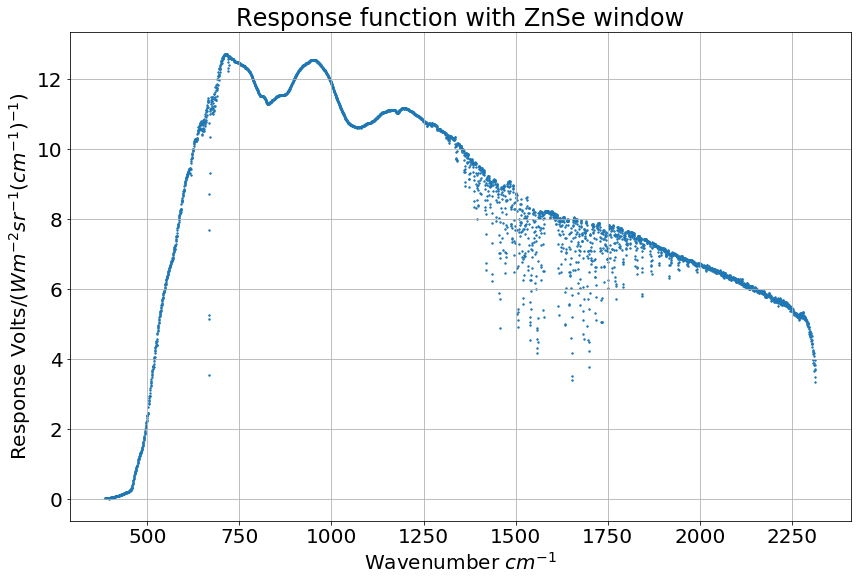

In [33]:
#Plot response function of any spectrum by changing n (0,175) representing times
def plot_resp_wn(n):
    fig = plt.figure(figsize=(14,9))
    plt.scatter(wavenums, all_resp_functions[n], s=2)
    plt.title('Response function with ZnSe window', fontsize=24) #  for spectrum {}'.format(n)
    plt.xlabel('Wavenumber $cm^{-1}$', fontsize=20)
    plt.ylabel('Response Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)', fontsize=20)
    plt.tick_params(labelsize=20, labelcolor='black')
    plt.grid()
    #fig.savefig('Graphs/Sample_resp_function_ZnSe.png', dpi=600)
    plt.show()

fig = plot_resp_wn(len(all_resp_functions)-1)



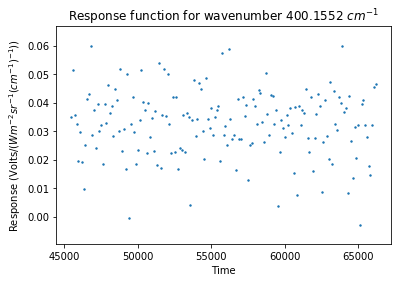

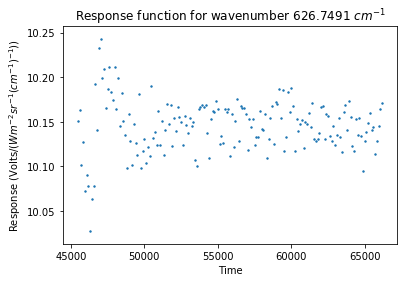

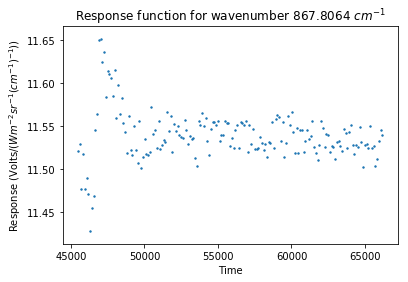

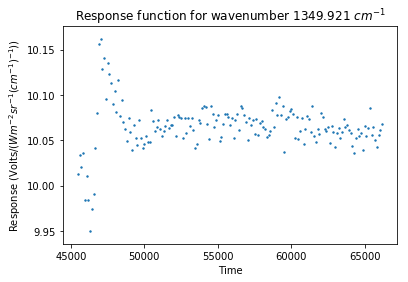

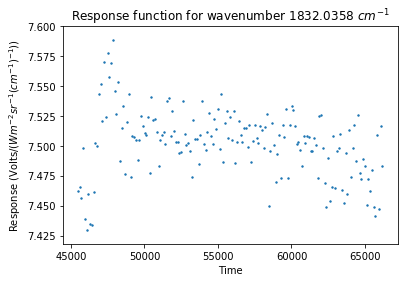

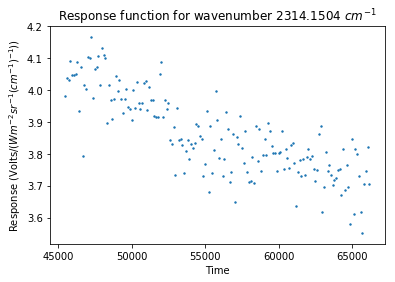

In [34]:
# Plot response function for any wavenumber over time by changing n(0 to 4000) representing wavenumbers (385-2314)cm^{-1}
def plot_resp_time(n):
    plt.scatter(spectra_times_4[1:-2:2], [i[n] for i in all_resp_functions], s=2)
    plt.title('Response function for wavenumber ' + str(wavenums[n]) + ' $cm^{-1}$')
    plt.xlabel('Time')
    plt.ylabel('Response (Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$))')
    plt.show()

plot_resp_time(30)
plot_resp_time(500)
plot_resp_time(1000)
plot_resp_time(2000)
plot_resp_time(3000)
plot_resp_time(4000)

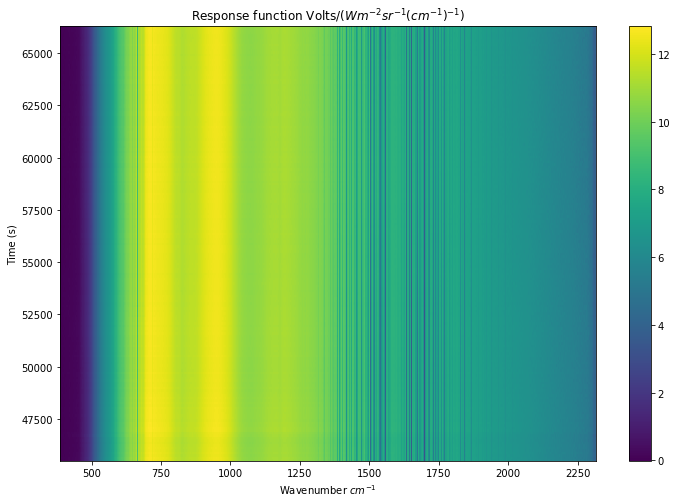

In [35]:
fig, ax = plt.subplots(figsize=(12,8))

p = ax.pcolor(wavenums, spectra_times_4[1::2], all_resp_functions)
cb = fig.colorbar(p)
plt.title('Response function Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
plt.show()

Can see that response function is roughly constant over time.
We probably want the highest response function in lower wavenumbers. This justifies trying to change the window of the spectrometer

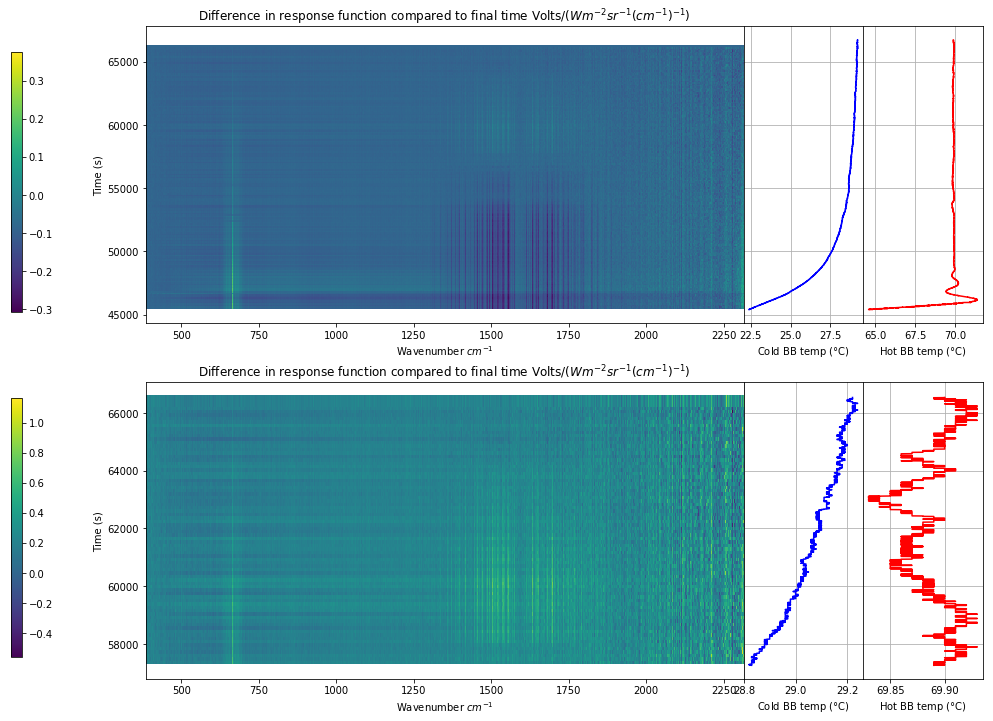

In [36]:
# Plot the difference in response function between the beginning time of the graph and all other times

grid = plt.GridSpec(2, 7, wspace=0, hspace=0.2)

fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(grid[0,:5])
plot_diff = ax1.pcolor(wavenums, spectra_times_4[1::2], diff_resp_functions)
plt.title('Difference in response function compared to final time Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
cbaxes = fig.add_axes([0, 0.15, 0.01, .3]) 
cb = fig.colorbar(plot_diff, cax = cbaxes)

# zoom into later times
ax2 = fig.add_subplot(grid[1,:5])
plot_diff = ax2.pcolor(wavenums, spectra_times_4[200::2], diff_resp_functions[98:])
plt.title('Difference in response function compared to final time Volts/($W m^{-2} sr^{-1} (cm^{-1})^{-1}$)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
cbaxes1 = fig.add_axes([0, 0.55, 0.01, .3]) 
cb = fig.colorbar(plot_diff, cax = cbaxes1)

ax3 = fig.add_subplot(grid[0,5:6], sharey = ax1)
ax3.plot(temp_cold, temp_time, 'b')
plt.grid()
plt.xlabel('Cold BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

ax4 = fig.add_subplot(grid[0,6:7], sharey = ax1)
ax4.plot(temp_hot, temp_time, 'r')
plt.grid()
plt.xlabel('Hot BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)
    
ax5 = fig.add_subplot(grid[1,5:6], sharey = ax2)
ax5.plot(temp_cold[5600:-100], temp_time[5600:-100], 'b')
plt.grid()
plt.xlabel('Cold BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

ax6 = fig.add_subplot(grid[1,6:7], sharey = ax2)
ax6.plot(temp_hot[5600:-100], temp_time[5600:-100], 'r')
plt.grid()
plt.xlabel('Hot BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

plt.show()

CO2 line at 667 - something happens after a couple of hours whereby response function of CO2 suddenly decreases. Could be due to change of CO2 concentration in room, or change in room temperature.

Water vapour response function on the other hand increases.

Calculate fractional standard deviation of response function for better understanding

$\textbf{Standard Deviation of response function calculation}$
    
Response Function = $I$ = $\frac{V_H - V_C}{L_H - L_C}$

$\sigma(I) = \sigma({\frac{V_H - V_C}{L_H - L_C}})$

treat $V_H - V_C$ as a constant

$\sigma(I) = (V_H - V_C) \times \frac{1}{{(L_H - L_C)}^2} \times \sigma(L_H - L_C)$

$\sigma(I) = (V_H - V_C) \times \frac{1}{{(L_H - L_C)}^2} \times \sqrt{({\sigma_{L_H}}^2 + {\sigma_{L_C}}^2)}$

In [37]:
def finding_std_dev(spec_num): #fractional std dev of response function based on standard dev of temperatures recorded during the spectrum- may need to realign lengths of "average_4_spectra" and "final_frame_4" so they align

    (a,b,c,d) = (final_frame_4.at[spec_num,'temp_avg'], final_frame_4.at[spec_num+1,'temp_avg'], final_frame_4.at[spec_num,'temp_std'], final_frame_4.at[spec_num+1,'temp_std'])
    if a<b:
        T_c = a
        T_h = b
        std_dev_Tc = c
        std_dev_Th = d
    else:
        T_c = b
        T_h = a
        std_dev_Tc = d
        std_dev_Th = c

    L_h = [planck(wn, T_h+273.15) for wn in wavenums] #radiance of HBB @ spec_num or spec_num+1
    L_h_plus = [planck(wn, T_h+273.15+std_dev_Th) for wn in wavenums] #spectrum of radiance + 1 std dev of radiance of HBB
    L_h_std = np.array(L_h_plus) - np.array(L_h) #spectrum of radiance std dev of HBB
    
    L_c = [planck(wn, T_c+273.15) for wn in wavenums] #radiance curve of CBB @ spec_num or spec_num+1
    L_c_plus = [planck(wn, T_c+273.15+std_dev_Tc) for wn in wavenums] #spectrum of radiance + 1 std dev of radiance of CBB
    L_c_std = np.array(L_c_plus) - np.array(L_c)
    
    L_diff = np.array(L_h) - np.array(L_c)
    term2 = 1/(L_diff**2)                    
    term3 = np.sqrt(L_h_std**2 + L_c_std**2) 
    
    (e,f) = (average_4_spectra[spec_num], average_4_spectra[spec_num + 1])
    if e[1000] < f[1000]:
        V_c = e
        V_h = f
    else:
        V_c = f
        V_h = e
    V_diff = np.array(V_h)-np.array(V_c) #term1
    
    std_dev_resp_fn = V_diff * term2 * term3
    resp_fn = [i/j for (i,j) in zip(V_diff, L_diff)]
    perc_std_dev = [i*100/j for (i,j) in zip(std_dev_resp_fn, resp_fn)]
    
    return(perc_std_dev)

In [38]:
all_stand_devs = [finding_std_dev(spec) for spec in np.arange(1,len(spectra_times_4)-2, 2)]

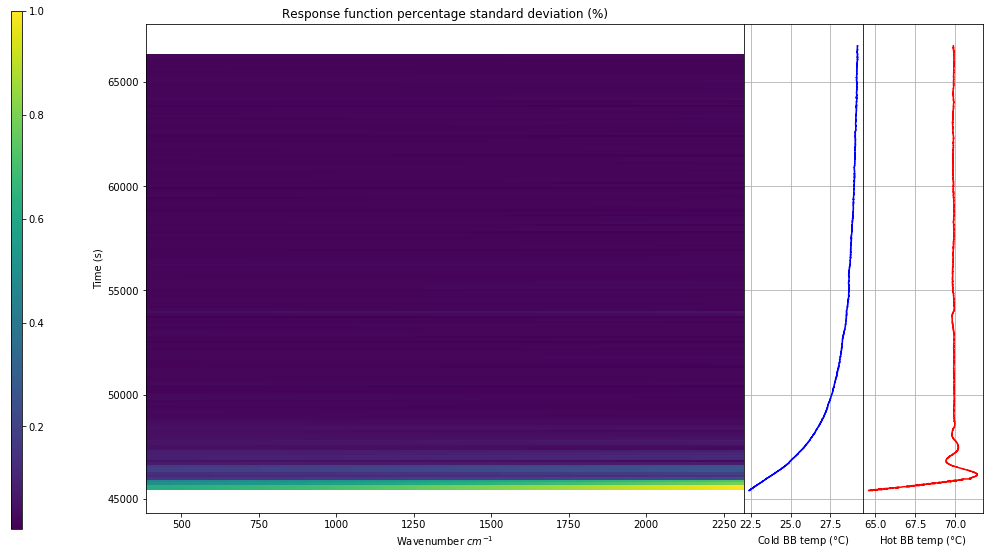

In [39]:
grid = plt.GridSpec(1, 7, wspace=0)

fig = plt.figure(figsize=(15,9))

ax1 = fig.add_subplot(grid[0,:5])
q = ax1.pcolor(wavenums, spectra_times_4[1::2], all_stand_devs)
plt.title('Response function percentage standard deviation (%)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
cb = fig.colorbar(q, cax = cbaxes)

ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
ax2.plot(temp_cold, temp_time, 'b')
plt.grid()
plt.xlabel('Cold BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
ax3.plot(temp_hot, temp_time, 'r')
plt.grid()
plt.xlabel('Hot BB temp ($\degree$C)')
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

plt.show()

Standard deviation is highest at beginning as expected. Zoom into later times:

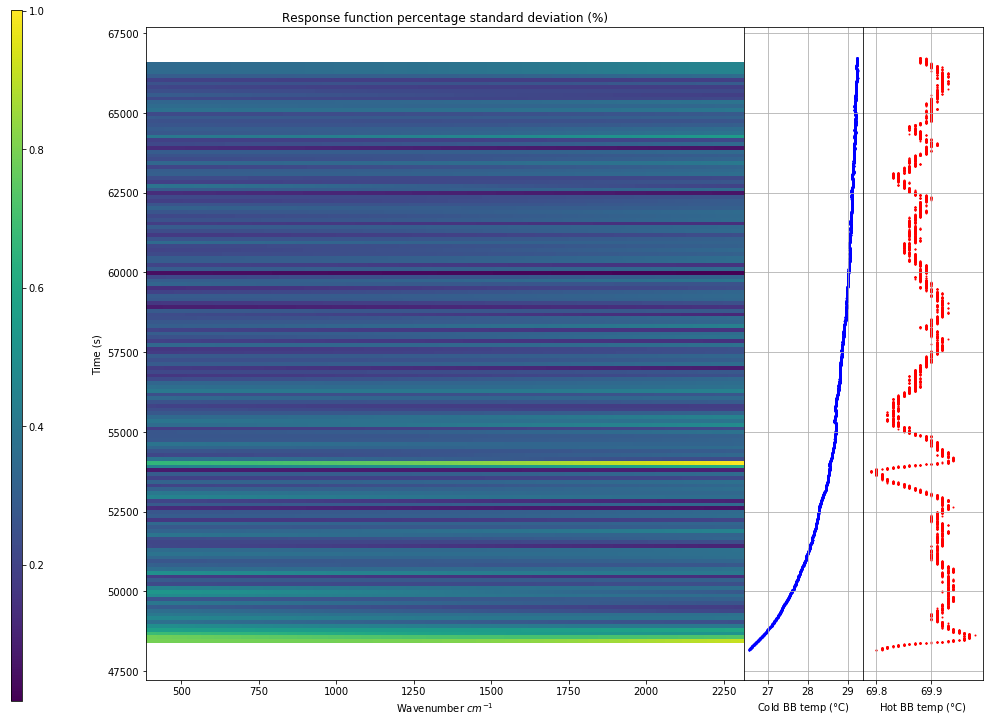

In [40]:
# zoom into later times after around 100 minutes

grid = plt.GridSpec(1, 7, wspace=0)

fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(grid[0,:5])
qq = ax1.pcolor(wavenums, spectra_times_4[50::2], all_stand_devs[24:])
plt.title('Response function percentage standard deviation (%)')
plt.xlabel('Wavenumber $cm^{-1}$')
plt.ylabel('Time (s)')
cbaxes = fig.add_axes([0, 0.1, 0.01, .8]) 
cb = fig.colorbar(q, cax = cbaxes)

ax2 = fig.add_subplot(grid[0,5:6], sharey = ax1)
ax2.scatter(temp_cold[1300:], temp_time[1300:], c='b', s=1)
plt.xlabel('Cold BB temp ($\degree$C)')
plt.grid()
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

ax3 = fig.add_subplot(grid[0,6:7], sharey = ax1)
ax3.scatter(temp_hot[1300:], temp_time[1300:], c='r', s=1)
plt.xlabel('Hot BB temp ($\degree$C)')
plt.grid()
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,        
    labelleft=False)

plt.show()

Why are there horizontal lines?
each horizontal line represents one averaged spectrum. This means that the standard deviation varies more from spectrum to spectrum than from wavnumber to wavenumber. So once the apparatus has heated up, the standard deviation is due to the temperatures included in a given spectrum (sometimes more, sometimes less - statistical fluctuation)

Also, note the strong variation in hot temperature at time when response function suddenly increases.

In [41]:
# get sets of measurements for new window and blackbodies before the break
# try to do the same with standard deviation but based on the posterior std of the response function 

#if temperature is varying by less than a certain rate, then percentage of spectral response is expected to vary by less than X

In [78]:
# Now return to resonse functions, considera column of them and take the standard deviation of the first X from the back
# decide which wavenumber to take it for

def resp_from_end(wn): #there are two responses per wn
    wavenumber = wavenums[(wn-386)*2]
    wn_responses = [all_resp_functions[i][wn*2] for i in range(len(all_resp_functions))]
    
    #start taking the last 10 values and expand
    stds_from_back = [np.std(wn_responses[-10-i:-1]) for i in range(0, len(wn_responses)-10)]
    avgs_from_back = [np.average(wn_responses[-10-i:-1]) for i in range(0, len(wn_responses)-10)]
    fractional_stds_from_back = [a/b*100 for (a,b) in zip(stds_from_back,avgs_from_back)] #in percent
    
    return(stds_from_back, avgs_from_back, fractional_stds_from_back, wavenumber)

In [91]:
stds_from_back, avgs_from_back, fractional_stds_from_back, wavenumber = resp_from_end(500)

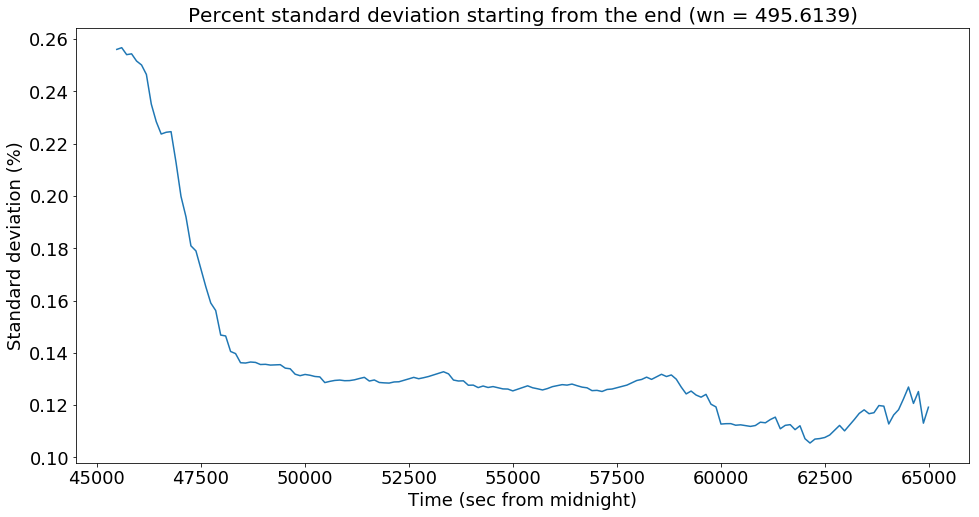

In [92]:
fig = plt.figure(figsize=(16, 8))
plt.plot(spectra_times_4[1:-22:2], fractional_stds_from_back[::-1])
plt.title('Percent standard deviation starting from the end (wn = {})'.format(wavenumber), fontsize=20)
plt.xlabel('Time (sec from midnight)', fontsize=18)
plt.ylabel('Standard deviation (%)', fontsize=18)
plt.tick_params(labelsize=18, labelcolor='black')
fig.savefig('Graphs/Percentage_rep_function_std_from_end.png', dpi=600)
plt.show()